In [1]:
import torch
import arviz as az
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show,output_file, save
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral
from bokeh.models import Slope, Div
from bokeh.io import curdoc,output_notebook,export_png
from bokeh.layouts import column,gridplot
#from print_versions import print_versions
from sklearn.metrics import r2_score
from seaborn import clustermap
from bokeh.models import Band, ColumnDataSource
import pandas as pd
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"

In [2]:
train=pd.read_excel(r"../data/chem_train.xlsx")
test=pd.read_excel(r"../data/chem_test.xlsx")

In [3]:
gpr_acetone=torch.load("../models/acetone_seasonality",weights_only=False,map_location='cuda')
gpr_form=torch.load("../models/form_seasonality",weights_only=False,map_location='cuda')
gpr_acetald=torch.load("../models/acetald_seasonality",weights_only=False,map_location='cuda')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
linmod=torch.linspace(0,52,800).to(device)
pm25_model,pm25_model_std=gpr_form(linmod,full_cov=True)

linmod_np=linmod.cpu().detach().numpy()
pm25_model_np,pm25_model_std_np=pm25_model.cpu().detach().numpy().copy(),pm25_model_std.diag().sqrt().cpu().detach().numpy().copy()

lower1 = pm25_model_np - pm25_model_std_np
upper1 = pm25_model_np + pm25_model_std_np
data1=pd.DataFrame([linmod_np,lower1,upper1],index=["corrected_week","lower","upper"]).T
data1 = ColumnDataSource(data1.reset_index())

In [6]:

bc_model,bc_model_std=gpr_acetald(linmod, full_cov=True)
bc_model_np,bc_model_std_np=bc_model.cpu().detach().numpy().copy(),bc_model_std.diag().sqrt().cpu().detach().numpy().copy()

lower1_bc = bc_model_np - bc_model_std_np
upper1_bc = bc_model_np + bc_model_std_np
data1_bc=pd.DataFrame([linmod_np,lower1_bc,upper1_bc],index=["corrected_week","lower_bc","upper_bc"]).T
data1_bc = ColumnDataSource(data1_bc.reset_index())

In [7]:

ac_model,ac_model_std=gpr_acetone(linmod, full_cov=True)
ac_model_np,ac_model_std_np=ac_model.cpu().detach().numpy().copy(),ac_model_std.diag().sqrt().cpu().detach().numpy().copy()

lower1_ac = ac_model_np - ac_model_std_np
upper1_ac = ac_model_np + ac_model_std_np
data1_ac=pd.DataFrame([linmod_np,lower1_ac,upper1_ac],index=["corrected_week","lower_ac","upper_ac"]).T
data1_ac = ColumnDataSource(data1_ac.reset_index())

In [8]:
std=train.sort_values("corrected_week").rolling(50, min_periods=1,closed='both',step=1).std()
mean=train.sort_values("corrected_week").rolling(50, min_periods=1,closed='both',step=1).mean()
std.columns=std.columns+"_std"
mean=pd.concat([mean,std],axis=1)
lower1_std = mean.formaldehyd - mean.formaldehyd_std
upper1_std = mean.formaldehyd + mean.formaldehyd_std
lower1_bc_std  = mean.acetald - mean.acetald_std
upper1_bc_std  = mean.acetald + mean.acetald_std
lower1_ac_std  = mean.acetone - mean.acetone_std
upper1_ac_std  = mean.acetone + mean.acetone_std
mean["lower1_std_pm"]=lower1_std
mean["upper1_std_pm"]=upper1_std
mean["lower1_std_bc"]=lower1_bc_std
mean["upper1_std_bc"]=upper1_bc_std
mean["lower1_std_ac"]=lower1_ac_std
mean["upper1_std_ac"]=upper1_ac_std
mean=mean.dropna()
mean1 = ColumnDataSource(mean.reset_index())

In [9]:
output_notebook()
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"

Loading BokehJS ...

In [10]:
p = figure(x_range=(0, 53),y_range=(0, 50),tools=TOOLS);
p.title.text = r"$$Formaldehyd seasonality";
p.xgrid.grid_line_color=None;
p.ygrid.grid_line_alpha=0.5;
p.line(mean.corrected_week, mean.formaldehyd, line_width=3,color="green",legend_label="mean_roll=100");
p.line(linmod_np, pm25_model_np, line_width=3,color="red",legend_label="Gaussion model");
p.scatter(train.corrected_week, y=train.formaldehyd, color="blue", marker="dot", size=20, alpha=0.4,legend_label="raw points");
band = Band(base="corrected_week", lower="lower1_std_pm", upper="upper1_std_pm",source=mean1, fill_color="red", line_color="black",fill_alpha=0.5);
band1 = Band(base="corrected_week", lower="lower", upper="upper",source=data1,fill_alpha=0.5, fill_color="blue", line_color="black");

p.add_layout(band);
p.add_layout(band1);
p.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p.yaxis.axis_label = r'$$\frac{\mu g}{m^3} $$';
p1 = figure(x_range=(0, 53),y_range=(0, 20),tools=TOOLS);
p1.title.text = r"Acetald seasonality";
p1.xgrid.grid_line_color=None;
p1.ygrid.grid_line_alpha=0.5;
p1.line(mean.corrected_week, mean.acetald, line_width=3,color="green",legend_label="mean_roll=100");
p1.line(linmod_np, bc_model_np, line_width=3,color="red",legend_label="Gaussion model");
p1.scatter(train.corrected_week, y=train.acetald, color="blue", marker="dot", size=20, alpha=0.8,legend_label="raw points");
band2 = Band(base="corrected_week", lower="lower_bc", upper="upper_bc",source=data1_bc, fill_color="blue", line_color="black",fill_alpha=0.5);
band3 = Band(base="corrected_week", lower="lower1_std_bc", upper="upper1_std_bc",source=mean1, fill_color="red", line_color="black",fill_alpha=0.5);
p1.add_layout(band3);
p1.add_layout(band2);

p1.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p1.yaxis.axis_label = r'r$$ \frac{\mu g}{m^3} $$';
p1.legend.title_text_font_size = "16px";
p.legend.title_text_font_size = "16px";
p.xaxis.axis_label_text_font_size = "14px";
p.yaxis.axis_label_text_font_size = "14px";
p1.xaxis.axis_label_text_font_size = "14px";
p1.yaxis.axis_label_text_font_size = "14px";
p1.yaxis.axis_label_text_font_style = "bold";
p1.xaxis.axis_label_text_font_style = "bold";
p.yaxis.axis_label_text_font_style = "bold";
p.xaxis.axis_label_text_font_style = "bold";
p2 = figure(x_range=(0, 53),y_range=(0, 25),tools=TOOLS);
p2.title.text = r"Acetone seasonality";
p2.xgrid.grid_line_color=None;
p2.ygrid.grid_line_alpha=0.5;
p2.line(mean.corrected_week, mean.acetone, line_width=3,color="green",legend_label="mean_roll=100");
p2.line(linmod_np, ac_model_np, line_width=3,color="red",legend_label="Gaussion model");
p2.scatter(train.corrected_week, y=train.acetone, color="blue", marker="dot", size=20, alpha=0.8,legend_label="raw points");
band4 = Band(base="corrected_week", lower="lower_ac", upper="upper_ac",source=data1_ac, fill_color="blue", line_color="black",fill_alpha=0.5);
band5 = Band(base="corrected_week", lower="lower1_std_ac", upper="upper1_std_ac",source=mean1, fill_color="red", line_color="black",fill_alpha=0.5);
p2.add_layout(band4);
p2.add_layout(band5);

p2.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p2.yaxis.axis_label = r'r$$ \frac{\mu g}{m^3} $$';
p2.legend.title_text_font_size = "16px";
p2.legend.title_text_font_size = "16px";
p2.xaxis.axis_label_text_font_size = "14px";
p2.yaxis.axis_label_text_font_size = "14px";
p2.xaxis.axis_label_text_font_size = "14px";
p2.yaxis.axis_label_text_font_size = "14px";
p2.yaxis.axis_label_text_font_style = "bold";
p2.xaxis.axis_label_text_font_style = "bold";
p2.yaxis.axis_label_text_font_style = "bold";
p2.xaxis.axis_label_text_font_style = "bold";
grid =  gridplot([[p, p1,p2]], width=500, height=500);

show(column(grid));

In [11]:
no2_r2

NameError: name 'no2_r2' is not defined

In [11]:
form=gpr_form(torch.tensor(test.corrected_week.values).float().to(device))[0].cpu().detach().numpy()
acetald=gpr_acetald(torch.tensor(test.corrected_week.values).float().to(device))[0].cpu().detach().numpy()
acetone=gpr_acetone(torch.tensor(test.corrected_week.values).float().to(device))[0].cpu().detach().numpy()

In [12]:
no2_r2

NameError: name 'no2_r2' is not defined

In [13]:
r2_score(test.formaldehyd,form),r2_score(test.acetald,acetald),r2_score(test.acetone,acetone)

(-0.06806461270409692, -0.2813339138521964, -0.13318914810216143)

In [13]:
pyro_data_acetald=az.from_json("Arviz_stats/mcmc_acetald_seasonality.json")

In [14]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data_acetald,backend='bokeh')

array([[<Axes: ylabel='kernel.variance'>, <Axes: >],
       [<Axes: xlabel='kernel.lengthscale', ylabel='noise'>,
        <Axes: xlabel='kernel.variance'>]], dtype=object)

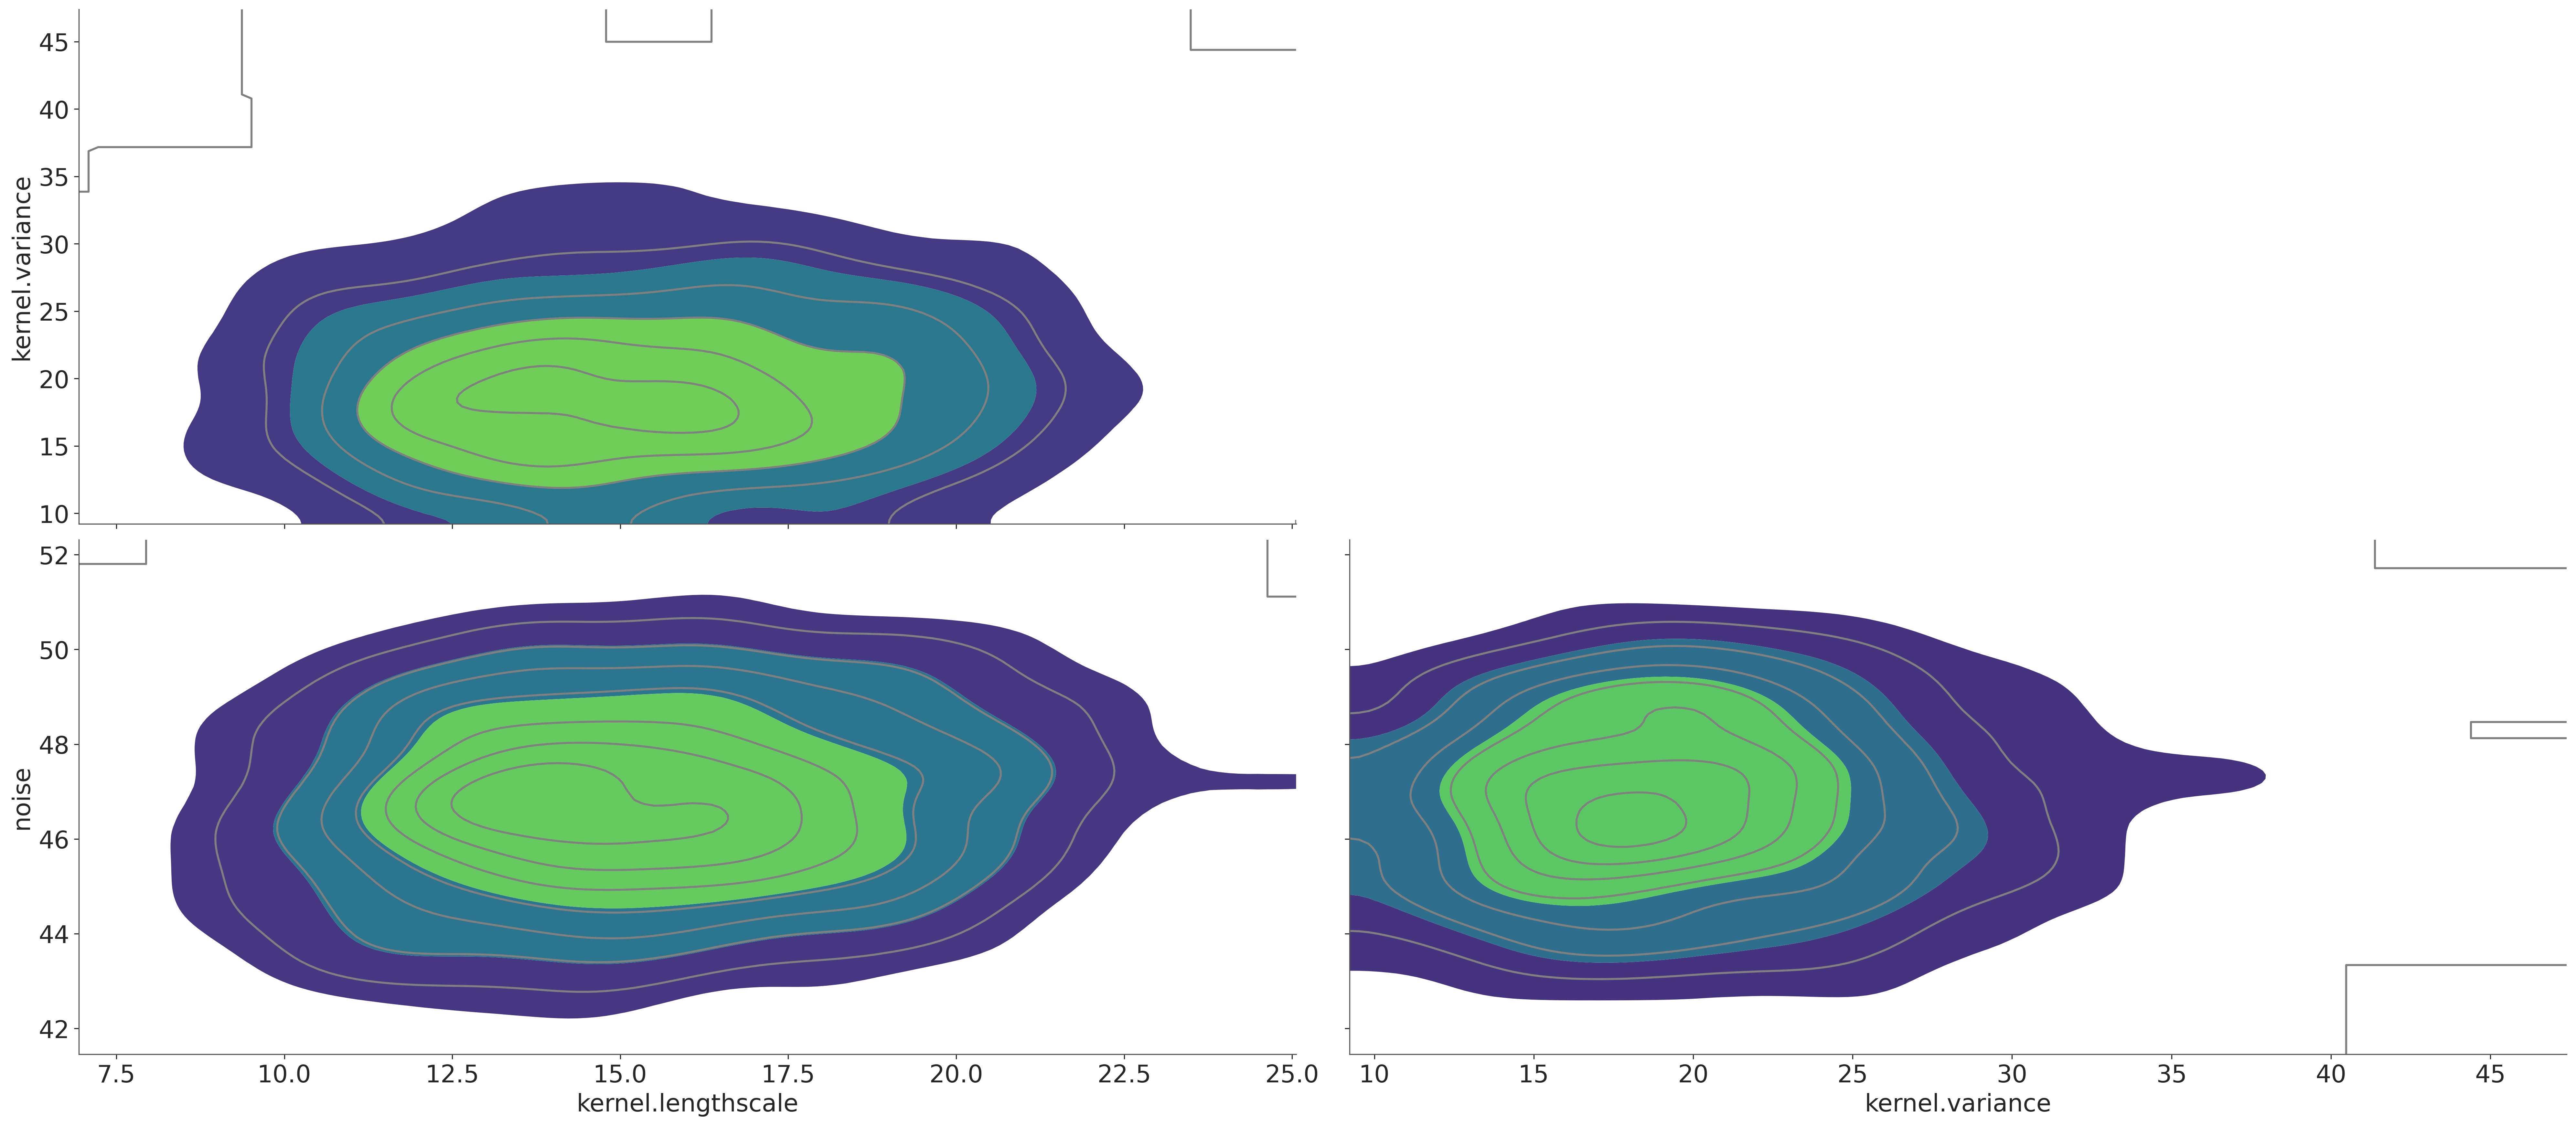

In [16]:
az.plot_pair(pyro_data_acetald,kind='kde',divergences=True,textsize=18)


In [19]:
pyro_data_acetone=az.from_json("Arviz_stats/mcmc_acetone_seasonality.json")

In [21]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data_acetone,backend='bokeh')

array([[<Axes: ylabel='kernel.variance'>, <Axes: >],
       [<Axes: xlabel='kernel.lengthscale', ylabel='noise'>,
        <Axes: xlabel='kernel.variance'>]], dtype=object)

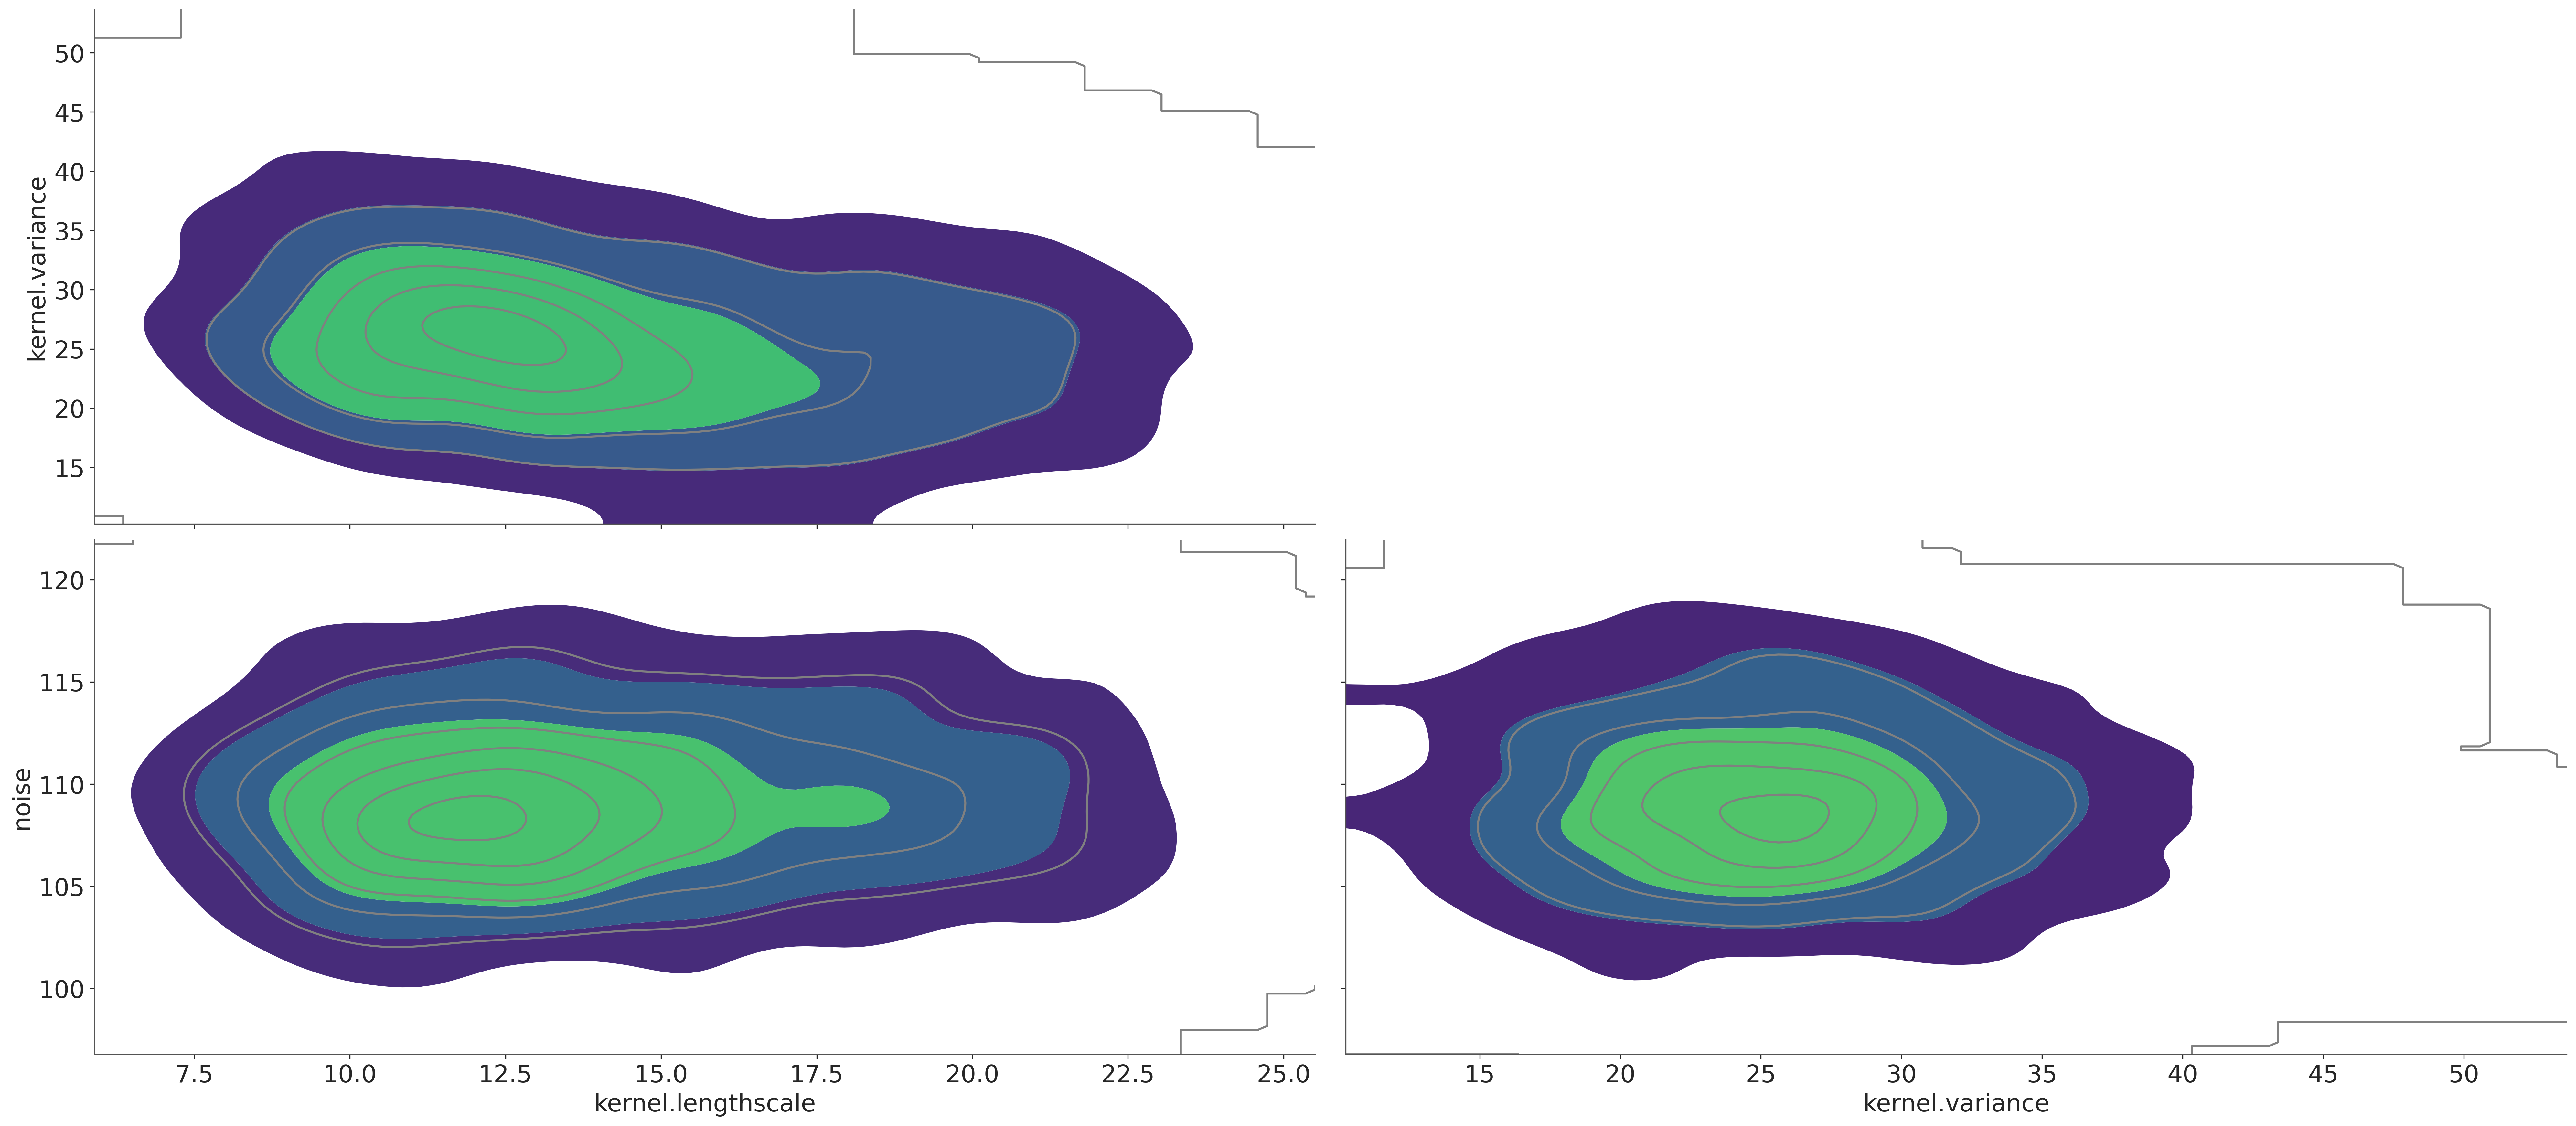

In [23]:
az.plot_pair(pyro_data_acetone,kind='kde',divergences=True,textsize=18)
